In [1]:
%cd ..

/homes/bjh30/miniforge3/envs/perm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/homes/bjh30/synth-permutations


In [11]:
import datetime
import os
import time
from glob import glob
from pathlib import Path
from types import SimpleNamespace

import hydra
from omegaconf import OmegaConf, DictConfig
import matplotlib.pyplot as plt
import pandas as pd
import torch

from src.utils import register_resolvers

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = "cpu" if not torch.cuda.is_available() else "cuda"

In [4]:
torch.set_grad_enabled(False)

In [210]:
def get_version(hparam_path):
    assert hparam_path.parent.name.startswith("version_")
    version = hparam_path.parent.name
    _, version = version.rsplit("_")
    version = int(version)
    return version

def get_ctime(file):
    timestamp = file.stat().st_ctime
    dt = datetime.datetime.fromtimestamp(timestamp)
    return dt

def get_nearest_ctime(hparam_path, checkpoints):
    hparam_ctime = get_ctime(hparam_path)
    opts = [c for c in checkpoints if "last" in c.name]
    return opts[0]
    # return min(opts, key=lambda c: abs((get_ctime(c) - hparam_ctime).total_seconds()))

def get_latest(checkpoints):
    opts = [c for c in checkpoints if "last" in c.name]
    if len(opts) > 1:
        print(opts)
    return max(opts, key=lambda c: get_ctime(c))

def get_checkpoint(hparam_path):
    version = get_version(hparam_path)
    
    ckpt_dir = hparam_path.parent.parent.parent / "checkpoints"
    if not ckpt_dir.exists():
        return None

    checkpoints = ckpt_dir.glob("*.ckpt")
    # print(checkpoints)
    # return get_latest(checkpoints)
    return get_nearest_ctime(hparam_path, checkpoints)
    # if version == 0:
    #     checkpoints = [c for c in checkpoints if c.name == "last.ckpt"]
    #     if len(checkpoints) == 0:
    #         return None
    # elif version > 0:
    #     checkpoints = [c for c in checkpoints if c.name == f"last-v{version}.ckpt"]
    #     if len(checkpoints) == 0:
    #         checkpoints = [c for c in checkpoints if c.name == f"last.ckpt"]
    #         if len(checkpoints) == 0:
    #             return None
    
    # return checkpoints[-1]

def get_max_epoch(hparam_path):
    try:
        return len(pd.read_csv(hparam_path.parent / "metrics.csv"))
    except:
        return 0


In [211]:
log_dir = Path("logs")
hparam_files = list(log_dir.glob("**/hparams.yaml"))

hparam_files = [h for h in hparam_files if get_max_epoch(h) >= 900]
ckpt_files = [get_checkpoint(h) for h in hparam_files]

hparam_files = [h for h,c in zip(hparam_files, ckpt_files) if c is not None]
ckpt_files = [c for c in ckpt_files if c is not None]

print(len(hparam_files))

63


In [212]:
def get_model_cls(model_idx):
    from importlib import import_module
    target = OmegaConf.load(hparam_files[model_idx]).model._target_
    mod, cls = target.rsplit(".", 1)
    mod = import_module(mod)
    return getattr(mod, cls)

def load_model(model_idx, device):
    cls = get_model_cls(model_idx)
    model = cls.load_from_checkpoint(ckpt_files[model_idx], device=device)
    return model

def load_dataset(model_idx, device):
    target = OmegaConf.load(hparam_files[model_idx]).data
    dm = hydra.utils.instantiate(target)
    dm.device = device
    dm.setup("test")
    return dm.test_dataloader()


In [213]:
def extract_metadata(hparam_file):
    cfg = OmegaConf.load(hparam_file)
    md = SimpleNamespace()
    if cfg.model._target_.endswith("KSinFlowMatchingModule"):
        md.model_family = "flow"
    elif cfg.model._target_.endswith("KSinFeedForwardModule"):
        md.model_family = "mlp"
    else:
        raise ValueError("Unknown model family")

    if cfg.data._target_.endswith("FMDataModule"):
        md.data_family = "fm"
    elif cfg.data._target_.endswith("KSinDataModule"):
        md.data_family = "ksin"

    md.ot = cfg.model.get("optimal_transport", False)
    md.loss_fn = cfg.model.get("loss_fn", None)
    md.k = cfg.data.get("k", 0.0)
    md.algorithm = cfg.data.get("algorithm", None)
    md.sort = cfg.data.get("sort_frequencies", False)
    md.break_symmetry = cfg.data.get("break_symmetry", False)

    md.date = get_ctime(hparam_file)

    return md.__dict__
    

rows = [extract_metadata(h) for h in hparam_files]

In [246]:
df = pd.DataFrame(rows)

df[((df.k == 2) & (~df.sort) & (~df.break_symmetry) & (df.model_family == "flow"))]

,model_family,data_family,ot,loss_fn,k,algorithm,sort,break_symmetry,date
8,flow,ksin,True,None,2.0,None,False,False,2024-12-18 18:28:40.284719
13,flow,ksin,True,None,2.0,None,False,False,2024-12-18 10:43:45.743510
15,flow,ksin,False,None,2.0,None,False,False,2024-12-18 18:28:58.978865
19,flow,ksin,False,None,2.0,None,False,False,2024-12-13 07:09:46.460220
43,flow,ksin,False,None,2.0,None,False,False,2024-12-14 08:03:16.689619


In [248]:
model_idx = 8
model = load_model(model_idx, device)
dl = load_dataset(model_idx, device)

In [249]:
model

KSinFlowMatchingModule(
  (encoder): SpectralResidualMLP(
    (0): ResidualMLPBlock(
      (net): Sequential(
        (0): LayerNorm((513,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=513, out_features=1024, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (residual): Linear(in_features=513, out_features=1024, bias=False)
    )
    (1): ResidualMLPBlock(
      (net): Sequential(
        (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (residual): Identity()
    )
    (2): ResidualMLPBlock(
      (net): Sequential(
        (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): GELU(approximate='none')


In [250]:
signal, params, render = next(iter(dl))
params = params[:1].expand(signal.shape[0], -1).clone()
signal = render(*params.chunk(2, -1), signal.shape[-1])

In [251]:
steps = 100
cfg = 5.0
old_data = False

print("Sampling...")
t = time.time()
sample, y, x = model._sample((signal, params, render), steps, cfg)
dur = time.time() - t
sps = steps / dur
print(f"Done. {steps} steps in {dur:.2f} seconds ({sps} steps/sec)")
if old_data:
    sample[..., :sample.shape[-1] // 2] = 2 * sample[..., :sample.shape[-1] // 2] / torch.pi - 1
    sample[..., sample.shape[-1] // 2:] = 2 * sample[..., sample.shape[-1] // 2:] - 1

yc = y.cpu()
sc = sample.cpu()
for i in range(y.shape[-1] // 2):
    for j in range(y.shape[-1] // 2):
        if i == j:
            continue
        
        plt.scatter(yc[:, i], yc[:, j], color="black")
for i in range(y.shape[-1] // 2):
    for j in range(y.shape[-1] // 2):
        if i == j:
            continue    
        plt.scatter(sc[:, i], sc[:, j], marker="+", color="red", alpha=0.05)
    
plt.xlim(-1, 1); plt.ylim(-1, 1)

Sampling...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x4 and 16x1024)

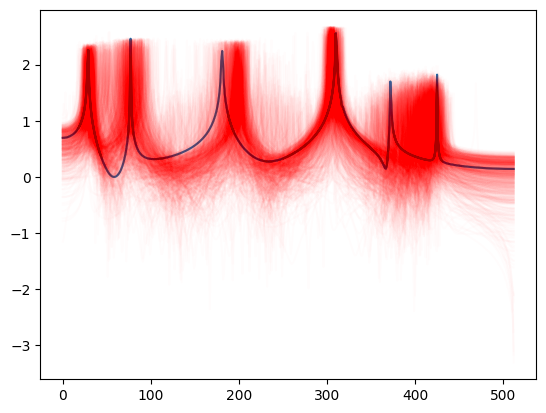

In [243]:
x_ = render(*sample.chunk(2, -1), x.shape[-1])

X = torch.fft.rfft(x).abs().log10()
X_ = torch.fft.rfft(x_).abs().log10()

plt.plot(X[0].cpu())
plt.plot(X_.T.cpu(), alpha = 0.01, color="red")
plt.show()

In [235]:
import ot as pot

In [223]:
def divmod(a, b):
    return torch.div(a, b, rounding_mode="floor"), torch.remainder(a, b)


def _sample_from_ot_map(x0: torch.Tensor, x1: torch.Tensor, z: torch.Tensor):
    batch_size = z.shape[0]
    a = pot.unif(x0.shape[0], type_as=x0)
    b = pot.unif(x1.shape[0], type_as=x1)
    costs = torch.cdist(x0, x1).sqrt()

    ot_map = pot.sinkhorn(a, b, costs, 0.1, method="sinkhorn", numItermax=1000, verbose=True, stopThr=1e-6)
    # ot_map = pot.emd(a, b, costs, numThreads=4)
    pi = ot_map.flatten().square()
    samples = torch.multinomial(pi, batch_size, replacement=True)

    i, j = divmod(samples, batch_size)

    x0 = x0[i]
    x1 = x1[j]
    z = z[j]

    return x0, x1, z


In [150]:
x0 = torch.randn(1024, 10, device=params.device)
x1 = torch.randn(1024, 10, device=params.device)
z = model.encoder(signal)
(x0 - x1).square().mean(dim=-1)

tensor([1.8026, 3.9801, 1.2254,  ..., 0.8886, 1.2468, 5.0028], device='cuda:0')

In [151]:
x0, x1, z = _sample_from_ot_map(x0, x1, z)
(x0 - x1).square().mean(dim=-1)

It.  |Err         
-------------------
    0|8.537869e-03|


tensor([0.2077, 0.2688, 0.3241,  ..., 0.4711, 0.1755, 0.6435], device='cuda:0')

In [109]:
next(iter(dl))[1]

tensor([[ 0.2754,  0.7154, -0.6227,  ...,  0.3728,  0.3263,  0.4755],
        [ 0.8504,  0.5885, -0.3681,  ..., -0.1016,  0.9631,  0.8970],
        [-0.4475, -0.5284, -0.0632,  ...,  0.9273,  0.7978,  0.8777],
        ...,
        [-0.8375, -0.8504,  0.4324,  ...,  0.3212, -0.9107,  0.8041],
        [-0.8321,  0.9268,  0.6149,  ..., -0.7404, -0.6362, -0.2814],
        [-0.5186, -0.9194, -0.8321,  ..., -0.4604,  0.4518,  0.9408]],
       device='cuda:0')